In [ ]:
# Clone the repository
!git clone https://github.com/rishika-nn/Capstone_Project
%cd Capstone_Project

# Install dependencies (including CLIP for multi-modal search)
print("📦 Installing dependencies... This will take 3-5 minutes")
%pip install -q opencv-python-headless pillow numpy pandas tqdm python-dotenv
%pip install -q torch torchvision transformers sentence-transformers
%pip install -q pinecone FlagEmbedding
# Note: transformers includes CLIP models for multi-modal search

print("\n✅ Installation complete!")

# Check GPU availability
import torch
if torch.cuda.is_available():
    print(f"\n🚀 GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("\n⚠️ No GPU detected. Using CPU (slower but works)")

Cloning into 'Capstone_Project'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 27 (delta 8), reused 24 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 75.73 KiB | 1.17 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/Capstone_Project
📦 Installing dependencies... This will take 3-5 minutes
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.6/587.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.3/259.3 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.1/866.1 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/4

In [4]:
!find /content -name ".env"


/content/.env


In [5]:
import os
from dotenv import load_dotenv

load_dotenv("/content/.env")
key = os.getenv("PINECONE_API_KEY")

print("Key Loaded:", bool(key))     # Should be True
print("Key Starts With:", key[:8])  # First few chars for verification


Key Loaded: True
Key Starts With: pcsk_6ke


### Pinecone setup: dual indexes (text + image)
Ensure two Pinecone indexes exist and match your config:
- Text index: dimension must match your text embedding model (default 1024)
- Image index: dimension must match CLIP image/text space (default 512)

Run the cell below to verify/create the indexes automatically using values from `video_search_config.Config`. You need `PINECONE_API_KEY` set.


In [6]:
# Verify or create Pinecone text/image indexes per config
import os, time
from video_search_config import Config
from pinecone import Pinecone, ServerlessSpec

# Use the API key loaded from environment variables
pinecone_api_key = os.getenv('PINECONE_API_KEY')
assert pinecone_api_key, "PINECONE_API_KEY is required"

pc = Pinecone(api_key=pinecone_api_key)
existing = {idx.name for idx in pc.list_indexes()}

needed = [
    (Config.PINECONE_TEXT_INDEX_NAME, Config.PINECONE_TEXT_DIMENSION),
    (Config.PINECONE_IMAGE_INDEX_NAME, Config.PINECONE_IMAGE_DIMENSION),
]

for name, dim in needed:
    if name in existing:
        print(f"✅ Index exists: {name}")
        # sanity check dimension (best-effort)
        try:
            idx = pc.Index(name)
            stats = idx.describe_index_stats()
            actual_dim = stats.get('dimension')
            if actual_dim and int(actual_dim) != int(dim):
                print(f"⚠️ Dimension mismatch for {name}: index={actual_dim} config={dim}")
            else:
                print(f"   Dimension OK: {dim}")
        except Exception as e:
            print(f"   (warn) Could not verify dimension for {name}: {e}")
    else:
        print(f"📦 Creating index: {name} (dim={dim})")
        pc.create_index(
            name=name,
            dimension=int(dim),
            metric=Config.PINECONE_METRIC,
            spec=ServerlessSpec(cloud=Config.PINECONE_CLOUD, region=Config.PINECONE_REGION)
        )
        # brief wait
        time.sleep(5)
        print(f"   ✅ Created: {name}")

print("Done.")

✅ Index exists: capstone-text
   Dimension OK: 1024
✅ Index exists: capstone-image
   Dimension OK: 512
Done.


In [ ]:
# Initialize the video search engine
from video_search_engine import VideoSearchEngine

print("🚀 Initializing Video Search Engine...")
engine = VideoSearchEngine()
print("✅ Engine initialized and ready!")
print("\n📊 Features active:")
print("   - Multi-modal search (text + CLIP image embeddings)")
print("   - Temporal bootstrapping (fixed window for stationary cameras)")
print("   - Confidence-aware boosting")
print("   - Semantic frame deduplication")


In [7]:
# Unified search helper: optional upload flow + smart search with thumbnails
import os, time
import cv2
from PIL import Image
from IPython.display import display

# Assume engine is already initialized in prior cells
try:
    engine
except NameError:
    from video_search_engine import VideoSearchEngine
    engine = VideoSearchEngine()

# Helper to process a video if provided; else skip

def process_video_if_any(video_path: str = None, video_name: str = None):
    if video_path and os.path.exists(video_path):
        name = video_name or os.path.splitext(os.path.basename(video_path))[0]
        print(f"\n🎬 Processing video: {name}")
        stats = engine.process_video(
            video_path=video_path,
            video_name=name,
            save_frames=False,
            upload_to_pinecone=True,
            use_object_detection=False
        )
        print("✅ Processing complete.")
        return name, stats
    else:
        print("ℹ️ No video uploaded. Searching existing Pinecone index.")
        return None, None


def search_and_display(query: str, video_filter: str = None, top_k: int = 5):
    print(f"\n🔎 Query: {query}")
    results = engine.smart_search(
        query=query,
        top_k=top_k,
        video_filter=video_filter
    )
    if not results:
        print("No results found.")
        return

    for i, r in enumerate(results, 1):
        ts = r.get('timestamp', 0.0)
        print(f"{i}. ⏱ {r.get('time_formatted','')}  📊 {r.get('similarity_score',0):.0%}")
        print(f"   📝 {r.get('caption','')}")
        print(f"   🎥 {r.get('video_name','')}")
        thumb_path = r.get('thumbnail_path')
        if thumb_path and os.path.exists(thumb_path):
            try:
                img = Image.open(thumb_path)
                display(img)
            except Exception:
                pass
        elif r.get('video_name') in getattr(engine, 'video_paths', {}):
            # Fallback: extract and show directly
            vpath = engine.video_paths[r['video_name']]
            cap = cv2.VideoCapture(vpath)
            if cap.isOpened():
                fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
                frame_num = int(max(0, ts) * fps)
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
                ok, frame = cap.read()
                cap.release()
                if ok and frame is not None:
                    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    display(Image.fromarray(rgb))
    return results



# Video Frame Search System with InstructBLIP & Pinecone

Multi-modal video semantic search optimized for stationary surveillance cameras:
- Extracts frames with semantic deduplication (CLIP-based)
- Generates object-focused captions using InstructBLIP
- Stores dual embeddings (text + CLIP image) in Pinecone
- Multi-modal search with temporal bootstrapping

**Features:**
- 🎯 Object-focused captioning (detects colors, attributes like "black backpack", "red shirt")
- 🚀 Temporal bootstrapping (finds related objects at similar timestamps with fixed window)
- 📊 Multi-modal search (fuses text + image embeddings for better accuracy)
- ⚡ Confidence-aware boosting (weights results by detection confidence)
- 🖼️ Semantic deduplication (removes duplicate frames using CLIP embeddings)

---


 ## Step 1: Setup - Clone Repository & Install Dependencies



In [8]:
# Verify imports work correctly
try:
    from video_search_engine import VideoSearchEngine
    print("✅ All modules loaded successfully!")
    print("📝 Using InstructBLIP model for object-focused captioning")
except Exception as e:
    print(f"⚠️ Import error: {e}")
    print("   Please check that all files are in the correct directory")


✅ All modules loaded successfully!
📝 Using InstructBLIP model for object-focused captioning


## Step 2: Configure Pinecone API Key

The system will load credentials from a `.env` file. If the file doesn't exist, you'll be prompted to create it.

**Required settings:**
- **API Key**: Your Pinecone API key
- **Index Host**: Your index URL (from Pinecone dashboard)
- **Environment**: Usually `us-east-1` or your Pinecone region

## Step 4: Upload a Video File



In [10]:
from google.colab import files
import os
import subprocess
from urllib.parse import urlparse, parse_qs

print("📤 Choose how to get your video:\n")
print("1. Upload from computer (recommended for small files < 100MB)")
print("2. Download from URL (direct video file)")
print("3. Download from YouTube URL\n")

choice = input("Enter choice (1/2/3): ").strip()
video_path = None

if choice == "1":
    print("\n📁 Please select your video file...")
    uploaded = files.upload()
    if uploaded:
        video_path = list(uploaded.keys())[0]
        print(f"✅ Uploaded: {video_path}")
    else:
        print("❌ No file uploaded")

elif choice == "2":
    video_url = input("\nEnter video URL (direct link to .mp4, .avi, etc.): ").strip()

    if not video_url:
        print("❌ No URL provided")
    else:
        # Extract filename from URL or use default
        parsed_url = urlparse(video_url)
        url_filename = os.path.basename(parsed_url.path)

        # Use URL filename if it has an extension, otherwise use default
        if url_filename and '.' in url_filename:
            video_filename = url_filename
        else:
            video_filename = "downloaded_video.mp4"

        print(f"⬇️ Downloading from URL...")
        print(f"   Target file: {video_filename}")

        try:
            # Use subprocess for better control
            result = subprocess.run(
                ['wget', '-O', video_filename, video_url, '--no-check-certificate', '-q', '--show-progress'],
                capture_output=True,
                text=True,
                timeout=300
            )

            if result.returncode == 0 and os.path.exists(video_filename):
                if os.path.getsize(video_filename) > 0:
                    video_path = video_filename
                    print(f"✅ Downloaded successfully: {video_filename}")
                else:
                    print(f"❌ Download failed: File is empty")
                    if os.path.exists(video_filename):
                        os.remove(video_filename)
            else:
                print(f"❌ Download failed: wget returned code {result.returncode}")
                # Try alternative method with curl
                print("\n🔄 Trying alternative download method (curl)...")
                result2 = subprocess.run(
                    ['curl', '-L', '-o', video_filename, video_url, '--silent', '--show-error'],
                    capture_output=True,
                    text=True,
                    timeout=300
                )

                if result2.returncode == 0 and os.path.exists(video_filename) and os.path.getsize(video_filename) > 0:
                    video_path = video_filename
                    print(f"✅ Downloaded successfully with curl: {video_filename}")
                else:
                    print(f"❌ Alternative download also failed")
                    print("   Please check if the URL is accessible and try again")

        except subprocess.TimeoutExpired:
            print("❌ Download timed out (>5 minutes). File may be too large.")
        except Exception as e:
            print(f"❌ Download error: {e}")

elif choice == "3":
    youtube_url = input("\nEnter YouTube URL (video or shorts): ").strip()

    if not youtube_url:
        print("❌ No URL provided")
    else:
        print("⬇️ Downloading from YouTube...")
        print("   Installing yt-dlp (if needed)...")

        # Install yt-dlp if not present
        subprocess.run(['pip', 'install', '-q', 'yt-dlp'], check=False)

        video_filename = "youtube_video.mp4"

        try:
            print(f"   Fetching video info...")

            # Download with yt-dlp
            result = subprocess.run(
                [
                    'yt-dlp',
                    '-f', 'best[ext=mp4]/best',  # Best quality MP4
                    '-o', video_filename,
                    '--no-playlist',
                    '--quiet',
                    '--progress',
                    youtube_url
                ],
                capture_output=True,
                text=True,
                timeout=600  # 10 minute timeout for YouTube
            )

            if result.returncode == 0 and os.path.exists(video_filename):
                if os.path.getsize(video_filename) > 0:
                    video_path = video_filename
                    print(f"✅ Downloaded successfully: {video_filename}")
                else:
                    print(f"❌ Download failed: File is empty")
                    if os.path.exists(video_filename):
                        os.remove(video_filename)
            else:
                print(f"❌ YouTube download failed")
                if result.stderr:
                    print(f"   Error: {result.stderr[:300]}")
                print("\n💡 Troubleshooting tips:")
                print("   - Make sure the video is public and not age-restricted")
                print("   - Try using Option 1 to upload the video manually")
                print("   - Check if the URL is correct")

        except subprocess.TimeoutExpired:
            print("❌ Download timed out (>10 minutes).")
        except Exception as e:
            print(f"❌ Download error: {e}")

else:
    print("⚠️ Invalid choice. Please choose option 1, 2, or 3.")

# Validate the video file
if video_path:
    if os.path.exists(video_path):
        file_size = os.path.getsize(video_path) / (1024*1024)  # MB
        print(f"\n📹 Video ready: {video_path} ({file_size:.1f} MB)")

        # Verify it's a valid video file
        import cv2
        cap = cv2.VideoCapture(video_path)
        if cap.isOpened():
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration = frame_count / fps if fps > 0 else 0
            print(f"   Duration: {duration:.1f} seconds")
            print(f"   FPS: {fps:.1f}")
            print(f"   Total frames: {frame_count:,}")
            cap.release()
        else:
            print("\n⚠️ Warning: Unable to read video file. It may be corrupted.")
            print("   Please try a different video or URL.")
            video_path = None
    else:
        print(f"\n❌ Error: File not found at {video_path}")
        video_path = None

if not video_path:
    print("\n❌ No valid video file available. Please run this cell again.")

📤 Choose how to get your video:

1. Upload from computer (recommended for small files < 100MB)
2. Download from URL (direct video file)
3. Download from YouTube URL

Enter choice (1/2/3): 1

📁 Please select your video file...


Saving video2.mp4 to video2.mp4
✅ Uploaded: video2.mp4

📹 Video ready: video2.mp4 (3.1 MB)
   Duration: 94.1 seconds
   FPS: 30.0
   Total frames: 2,819


In [ ]:
# Using both InstructBLIP and Grounding DINO for enhanced object detection and captioning
print("📝 Using InstructBLIP + Grounding DINO for enhanced detection and captioning")
print("   - Grounding DINO: Precise object detection with location")
print("   - InstructBLIP: Detailed object descriptions (colors, sizes, etc.)")
print("   - Combined system provides better accuracy for classroom objects")
use_object_detection = True  # Enable enhanced object detection mode

📝 Using InstructBLIP for captioning
   Focuses on object attributes (colors, sizes, etc.)
   Better than standard BLIP for object descriptions like 'black backpack', 'red shirt'


## Step 5: Process the Video

This will:
1. Extract frames from the video
2. **Semantic deduplication** using CLIP embeddings (removes visually similar frames)
3. **Object detection** using enhanced Grounding DINO (precise object detection)
4. Generate captions using **InstructBLIP** (object-focused with colors and attributes)
5. Create **dual embeddings**: text embeddings (sentence-transformers) + CLIP image embeddings
6. Upload to Pinecone **dual indexes** (text + image) with structured metadata tags

**Expected time:**
- 1 minute video: ~4-5 minutes with GPU
- 5 minute video: ~12-15 minutes with GPU
- CPU mode: 4-6x slower

**Enhanced Features:**
- Improved object detection specifically for classroom items (backpacks, laptops, etc.)
- Semantic deduplication keeps only meaningful visual changes
- Combined Grounding DINO + InstructBLIP for better accuracy
- Dual embeddings enable multi-modal search (text + visual similarity)
- Structured tags (colors, objects) improve retrieval accuracy

In [ ]:
import time
from datetime import datetime

if 'video_path' not in locals() or not video_path:
    print("❌ Please upload a video first (run the previous cell)")
else:
    # Set video name
    video_name = input("Enter a name for this video (or press Enter for auto-name): ").strip()
    if not video_name:
        video_name = f"video_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    print(f"\n🎬 Processing video: {video_name}")
    print("⏳ This will take a few minutes... Please wait.\n")
    print("=" * 60)

    start_time = time.time()

    try:
        # Process the video with both Grounding DINO and InstructBLIP
        stats = engine.process_video(
            video_path=video_path,
            video_name=video_name,
            save_frames=False,  # Set to True to save frames
            upload_to_pinecone=True,
            use_object_detection=True  # Using enhanced Grounding DINO + InstructBLIP
        )

        processing_time = time.time() - start_time

        print("\n" + "=" * 60)
        print("\n✅ VIDEO PROCESSING COMPLETE!\n")
        print(f"📊 Processing Statistics:")
        print(f"   Video name: {video_name}")
        print(f"   Frames extracted: {stats['total_frames_extracted']:,}")
        print(f"   Frames with captions: {stats['frames_with_captions']:,}")
        print(f"   Objects detected: {stats.get('objects_detected', 0):,}")
        print(f"   Captions before dedupe: {stats.get('captions_before_dedupe', stats['frames_with_captions']):,}")
        print(f"   Unique embeddings: {stats.get('embeddings_generated', 0):,}")
        print(f"   ✅ Text embeddings uploaded: {stats.get('embeddings_uploaded_text', 0):,}")
        print(f"   🖼  Image embeddings uploaded: {stats.get('embeddings_uploaded_image', 0):,}")
        print(f"   Processing time: {processing_time/60:.1f} minutes")
        print(f"\n   Frame reduction: {stats.get('frame_reduction_percent', 0):.1f}%")

        # Save video_name for next steps
        processed_video_name = video_name

    except Exception as e:
        print(f"\n❌ Error processing video: {e}")
        print("\nTroubleshooting tips:")
        print("- If GPU memory error: Restart runtime and try again")
        print("- If video format error: Convert video to MP4 format")

Enter a name for this video (or press Enter for auto-name): 


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



🎬 Processing video: video_20251105_162149
⏳ This will take a few minutes... Please wait.



preprocessor_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

You are using a model of type instructblip to instantiate a model of type blip-2. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Blip2ForConditionalGeneration were not initialized from the model checkpoint at Salesforce/instructblip-flan-t5-xl and are newly initialized: ['qformer.layernorm.bias', 'qformer.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


Generating multi-captions: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading to Pinecone (image): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]




✅ VIDEO PROCESSING COMPLETE!

📊 Processing Statistics:
   Video name: video_20251105_162149
   Frames extracted: 1
   Frames with captions: 3
   Captions before dedupe: 3
   Unique embeddings: 2
   ✅ Text embeddings uploaded: 2
   🖼  Image embeddings uploaded: 3
   Processing time: 7.5 minutes

   Frame reduction: -200.0%


## Step 6: Search Your Video!

Multi-modal search using natural language queries. The system uses **temporal bootstrapping** to find related objects automatically!

**Features in action:**
- 🔄 **Temporal Bootstrapping**: Finds related objects at similar timestamps (fixed window for stationary cameras)
- 📊 **Multi-modal Fusion**: Combines text and image embeddings for better accuracy
- ⚡ **Confidence-Aware**: Weights results by detection confidence

**Example queries:**
- "person walking" → Also finds "bag", "backpack" nearby
- "red shirt" → Also finds "blue bag", "person" at similar times
- "black bag" → Also finds related objects in the same scenes

🎯 INTERACTIVE VIDEO SEARCH (Temporal Bootstrapping Active)
Type your query below. Type 'quit' to exit.

🔍 Enter search query: city

🔍 Searching for: 'city' ...
✨ Using: Temporal Bootstrapping + Adaptive Windows + Confidence-Aware Boosting

✅ Found 1 results for 'city':

1. ⏱️ 00:00.03
   📝 A city street with a city street with a city street with a city street.
   📊 Confidence: 66.3%
   🎥 Video: video_20251105_162149
   🖼️ Frame preview:


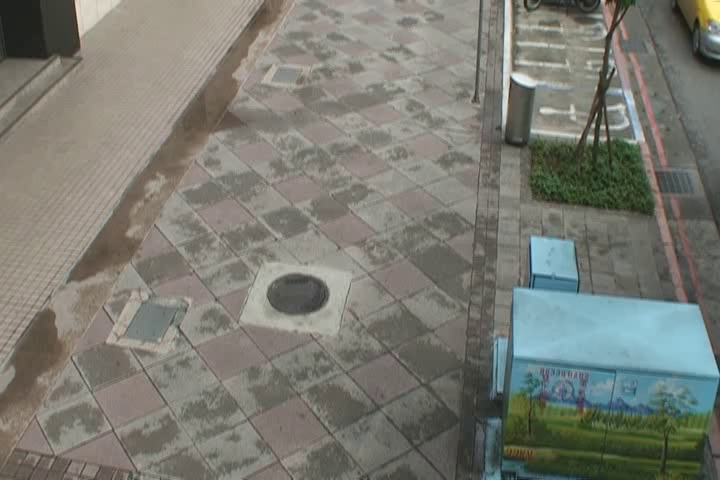

KeyboardInterrupt: Interrupted by user

In [ ]:
import cv2
from IPython.display import display
from PIL import Image

def display_frame_image(video_name: str, timestamp_sec: float):
    """Extract and display a frame image from the video at the given timestamp."""
    vpath = None
    if hasattr(engine, 'video_paths') and video_name in engine.video_paths:
        vpath = engine.video_paths.get(video_name)
    elif 'video_path' in globals():
        vpath = video_path

    if not vpath:
        print("   ⚠️ Could not locate video file to preview frame.")
        return

    cap = cv2.VideoCapture(vpath)
    if not cap.isOpened():
        print("   ⚠️ Unable to open video to extract frame.")
        return

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    frame_num = int(max(0, timestamp_sec) * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ok, frame = cap.read()
    cap.release()

    if not ok or frame is None:
        print("   ⚠️ Could not read frame at timestamp.")
        return

    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    display(img)


# -------------------------------------------
# INTERACTIVE TEMPORAL-BOOTSTRAP SEARCH LOOP
# -------------------------------------------

print("🎯 INTERACTIVE VIDEO SEARCH (Temporal Bootstrapping Active)")
print("=" * 60)
print("Type your query below. Type 'quit' to exit.\n")

while True:
    query = input("🔍 Enter search query: ").strip()

    if query.lower() in ['quit', 'exit', 'q']:
        print("\n👋 Goodbye!")
        break

    if not query:
        continue

    print(f"\n🔍 Searching for: '{query}' ...")
    print("✨ Using: Multi-modal search (text + image) with temporal bootstrapping\n")

    video_filter = processed_video_name if 'processed_video_name' in locals() else None
    
    # Use smart_search which routes simple/complex queries appropriately
    results = engine.smart_search(
        query=query,
        top_k=5,
        video_filter=video_filter
    )

    if results:
        print(f"✅ Found {len(results)} results for '{query}':\n")

        for i, result in enumerate(results, 1):
            print(f"{i}. ⏱️ {result['time_formatted']}")
            print(f"   📝 {result['caption']}")
            print(f"   📊 Confidence: {result['similarity_score']:.1%}")
            print(f"   🎥 Video: {result['video_name']}")

            # ✅ Only top-1 result shows frame preview
            if i == 1:
                print("   🖼️ Frame preview:")
                try:
                    display_frame_image(result['video_name'], float(result.get('timestamp', 0.0)))
                except Exception as e:
                    print(f"   ⚠️ Could not display frame: {e}")

            print()
    else:
        print("\n❌ No results found. Try different object wording or broaden query.\n")
